The OpenMeteo API contains historical weather data dating back decades. I'll be using it to pull daily temperature highs in Atlanta since 1990. I'll analyze the patterns of the data and then create a forecast for 2024.

In [99]:

import openmeteo_requests
from openmeteo_sdk.Variable import Variable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

om = openmeteo_requests.Client()


url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 33.75,
	"longitude": -84.38,
	"start_date": "1990-01-01",
	"end_date": "2023-12-31",
	"daily": "temperature_2m_max",
    "temperature_unit": "fahrenheit",

	
}
responses = om.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_temp_max = daily.Variables(0).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	#freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
daily_data["temperature_2m"] = daily_temp_max

daily_dataframe = pd.DataFrame(data = daily_data)
print(daily_dataframe)

Coordinates 33.77855682373047°N -84.40298461914062°E
Elevation 309.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
                           date  temperature_2m
0     1990-01-01 00:00:00+00:00       56.066002
1     1990-01-02 00:00:00+00:00       46.616001
2     1990-01-03 00:00:00+00:00       56.875999
3     1990-01-04 00:00:00+00:00       57.326000
4     1990-01-05 00:00:00+00:00       57.146000
...                         ...             ...
12413 2023-12-27 00:00:00+00:00       58.124298
12414 2023-12-28 00:00:00+00:00       51.914299
12415 2023-12-29 00:00:00+00:00       45.344299
12416 2023-12-30 00:00:00+00:00       43.544300
12417 2023-12-31 00:00:00+00:00       54.164299

[12418 rows x 2 columns]


Plotting the data 

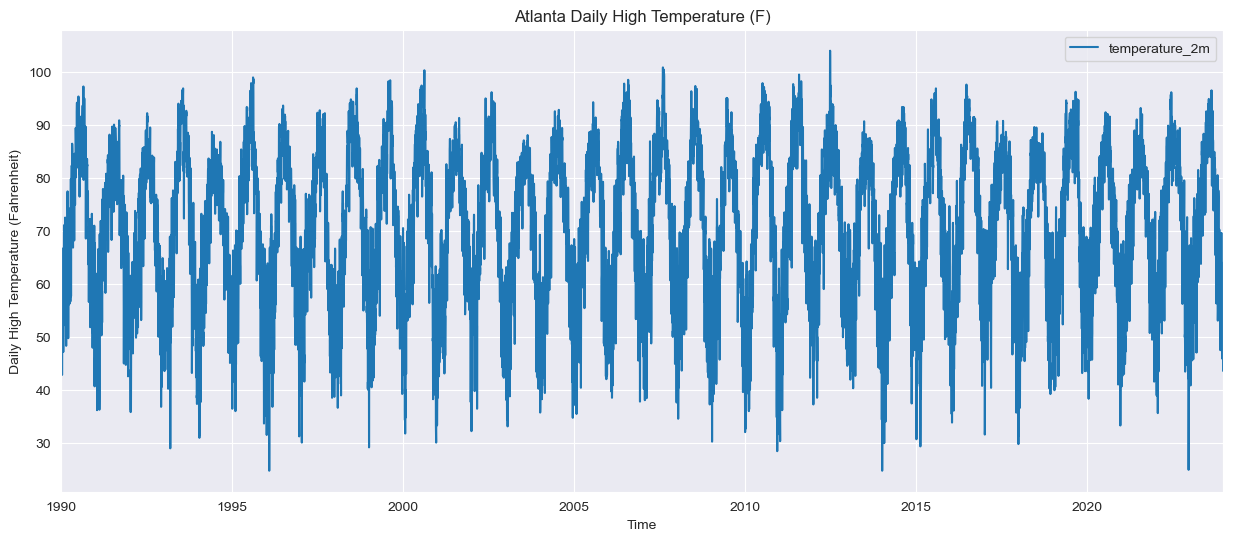

In [100]:


df = daily_dataframe.set_index('date')
#df.index = df.index.date
sns.set_style('darkgrid')
df.plot(
    figsize=(15,6),
    title= 'Atlanta Daily High Temperature (F)',
    xlabel = 'Time',
    ylabel = 'Daily High Temperature (Fahrenheit)'
   
    
)
plt.show()

Checking to see if data is stationary or has trend patterns with the ADF test. The p-value < 0.05 suggests the data is already stationary, so no differencing will be needed.

In [8]:
from statsmodels.tsa.stattools import adfuller


result = adfuller(df.dropna(), autolag='AIC')


print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -7.826864938894872
p-value: 6.446872985257324e-12
Critical Values: {'1%': -3.430878495220867, '5%': -2.8617735683884282, '10%': -2.566894323446312}


Adding more descriptive time features into our data, so I can group by other time periods for EDA purposes. We won't explicitly need to create lag features as the ARIMA/SARIMA model captures seasonal effects naturally

In [18]:


def add_time_features (df):
    '''
    Adds more date-time features to a dataframe assuming the index is DT
    
    '''
    dframe = df.copy()
    
    dframe['month'] = dframe.index.month
    dframe['quarter'] = dframe.index.quarter
    dframe['year'] = dframe.index.year
    dframe['day_of_yr'] = dframe.index.dayofyear
    
    
    seasons = {
        12: 'Winter',
        1: 'Winter',
        2: 'Winter',
        3: 'Spring',
        4: 'Spring',
        5: 'Spring',
        6: 'Summer',
        7: 'Summer',
        8: 'Summer',
        9: 'Fall',
        10: 'Fall',
        11: 'Fall'
    }
    
    dframe['season'] = dframe['month'].map(seasons)
    return dframe

df2 = add_time_features(df)
df2.head()
    


,temperature_2m,month,quarter,year,day_of_yr,season
date,,,,,,
1990-01-01 00:00:00+00:00,56.066002,1,1,1990,1,Winter
1990-01-02 00:00:00+00:00,46.616001,1,1,1990,2,Winter
1990-01-03 00:00:00+00:00,56.875999,1,1,1990,3,Winter
1990-01-04 00:00:00+00:00,57.326000,1,1,1990,4,Winter
1990-01-05 00:00:00+00:00,57.146000,1,1,1990,5,Winter


Looking several plots by time period (month, season, year) to get an idea of temperature patterns

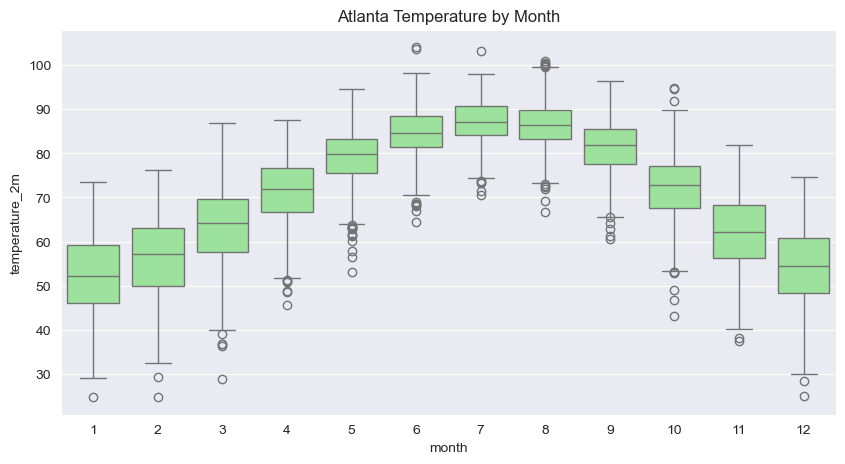

In [101]:

fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=df2, x='month', y='temperature_2m', color='lightgreen')
ax.set_title('Atlanta Temperature by Month')
plt.show()



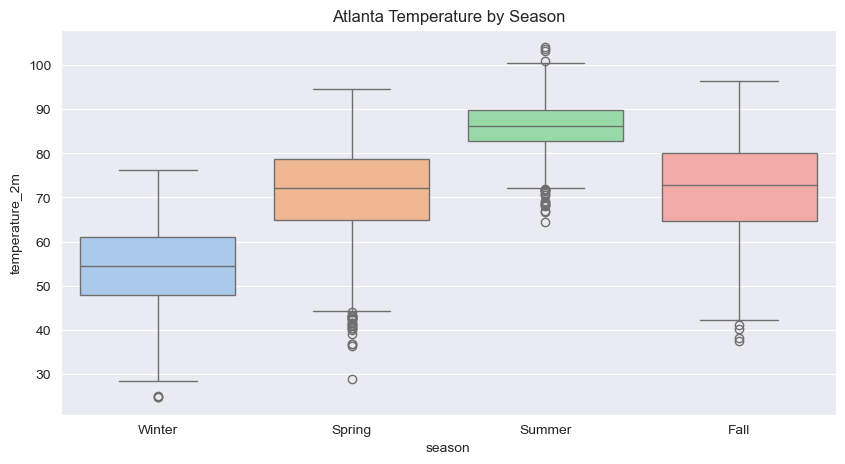

In [103]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=df2, x='season', y='temperature_2m', hue = 'season', palette='pastel')
ax.set_title('Atlanta Temperature by Season')
plt.show()

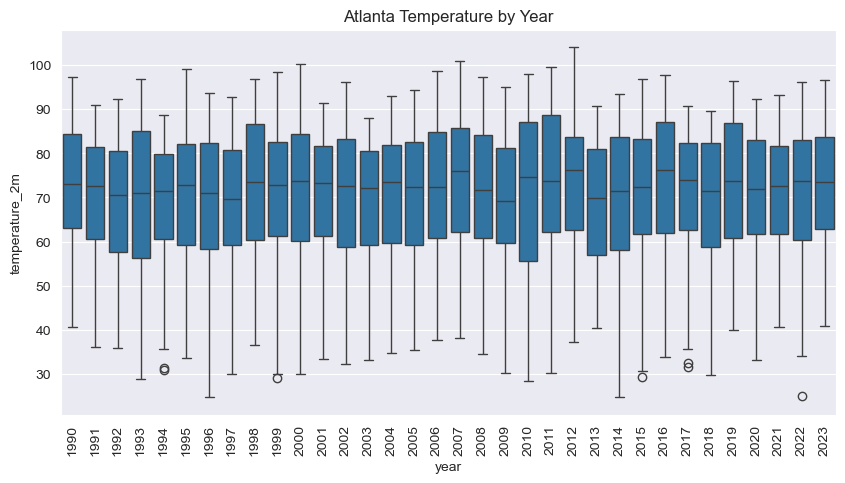

In [104]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=df2, x='year', y='temperature_2m')
ax.set_title('Atlanta Temperature by Year')
plt.xticks(rotation=90)
plt.show()

Looking at ACF plots to determine if differentiation is needed. The plots appear to show very high correlation, with a slight taper, indicating strong seasonality. This is what we'd expect for temperature data.

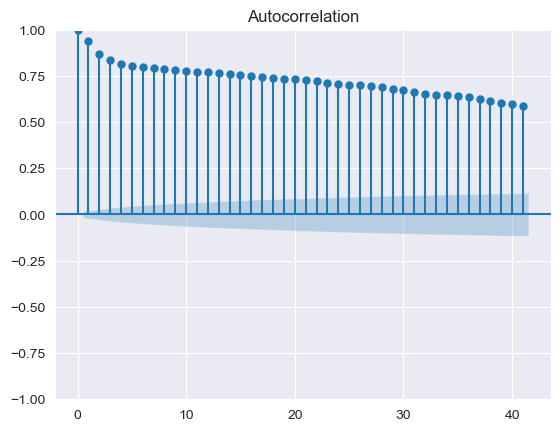

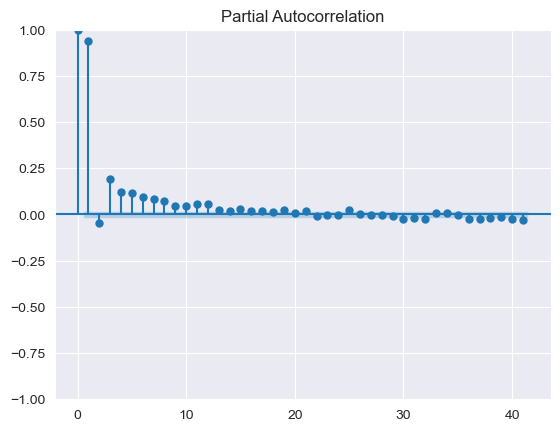

In [105]:
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from statsmodels.tsa.stattools import adfuller 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from sklearn.metrics import mean_absolute_error, mean_squared_error 


plot_acf(df) 
plot_pacf(df) 
plt.show()

Splitting the data into train/test splits. 2018 and onward is roughly 20% of the data, and provides a clean cut off for testing. Visualizing how our train/test split looks proportional to the data

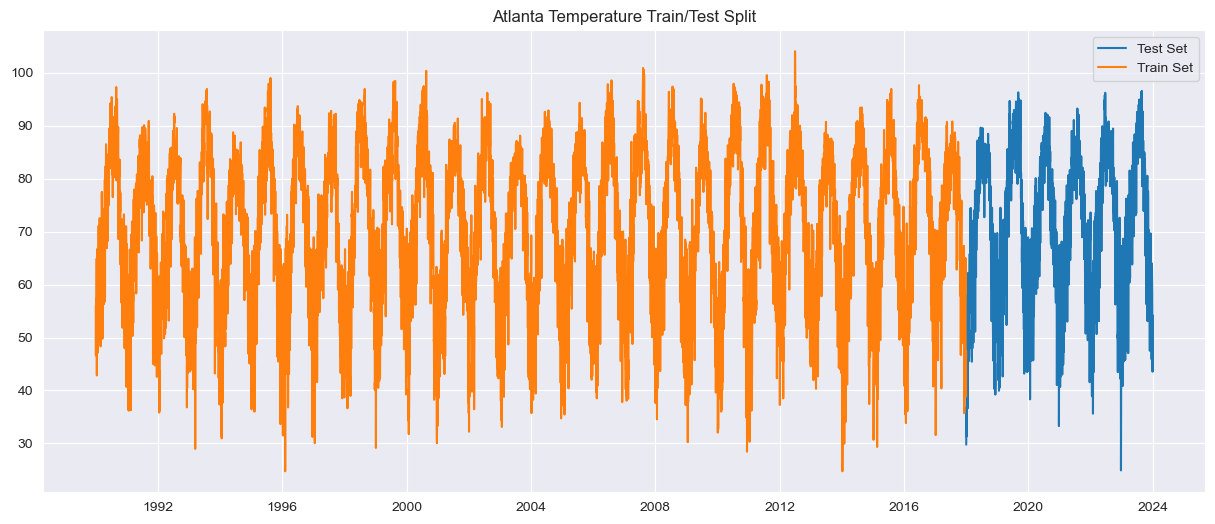

In [23]:
df3 = df.copy()
df3.index = df3.index.date

split_dt = pd.to_datetime('2018-01-01').date()

train = df3.loc[df3.index < split_dt]
test = df3.loc[df3.index >= split_dt]


test.rename(columns={"temperature_2m": 'Test Set'}) \
    .join(train.rename(columns={"temperature_2m": "Train Set"}),how='outer') \
    .plot(figsize=(15,6), title = 'Atlanta Temperature Train/Test Split', ms=1)
plt.show()

Creating the dataframe needed for the fb prophet model

In [37]:


train_fb = train.reset_index() \
    .rename(columns={'index': 'ds','temperature_2m': 'y'}) 
    
test_fb = test.reset_index() \
    .rename(columns={'index': 'ds','temperature_2m': 'y'}) 


In [35]:
train_fb.head()

,ds,y
0,1990-01-01,56.066002
1,1990-01-02,46.616001
2,1990-01-03,56.875999
3,1990-01-04,57.326000
4,1990-01-05,57.146000


Creating FB Prophet model and training

In [36]:

from prophet import Prophet
model = Prophet()
model.fit(train_fb)

18:19:20 - cmdstanpy - INFO - Chain [1] start processing
18:19:21 - cmdstanpy - INFO - Chain [1] done processing


In [39]:
test_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-01,71.551848,43.638196,61.113427,71.551848,71.551848,-19.003514,-19.003514,-19.003514,-0.002375,-0.002375,-0.002375,-19.001139,-19.001139,-19.001139,0.0,0.0,0.0,52.548334
1,2018-01-02,71.551871,43.622163,61.311919,71.551871,71.551871,-18.850826,-18.850826,-18.850826,0.170197,0.170197,0.170197,-19.021023,-19.021023,-19.021023,0.0,0.0,0.0,52.701045
2,2018-01-03,71.551894,44.000511,61.111088,71.551894,71.551894,-18.828254,-18.828254,-18.828254,0.207614,0.207614,0.207614,-19.035869,-19.035869,-19.035869,0.0,0.0,0.0,52.723640
3,2018-01-04,71.551917,43.168932,61.448786,71.551917,71.551917,-19.068085,-19.068085,-19.068085,-0.021338,-0.021338,-0.021338,-19.046747,-19.046747,-19.046747,0.0,0.0,0.0,52.483832
4,2018-01-05,71.551940,43.745398,61.223395,71.551940,71.551940,-19.141626,-19.141626,-19.141626,-0.086984,-0.086984,-0.086984,-19.054642,-19.054642,-19.054642,0.0,0.0,0.0,52.410314


Plotting the forecast to ensure the correct time periods.

/Users/cstone/anaconda3/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/cstone/anaconda3/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


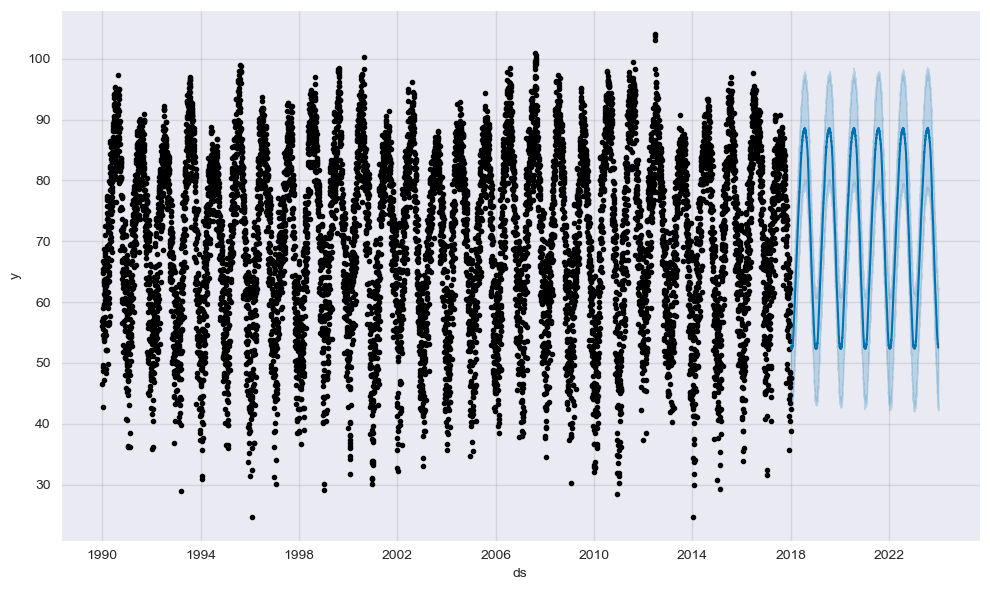

In [40]:
model.plot(test_forecast)
plt.show()

The Prophet package comes with many handy built-in visualization methods. This one looks at the trends over various time periods

/Users/cstone/anaconda3/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/cstone/anaconda3/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/Users/cstone/anaconda3/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To ret

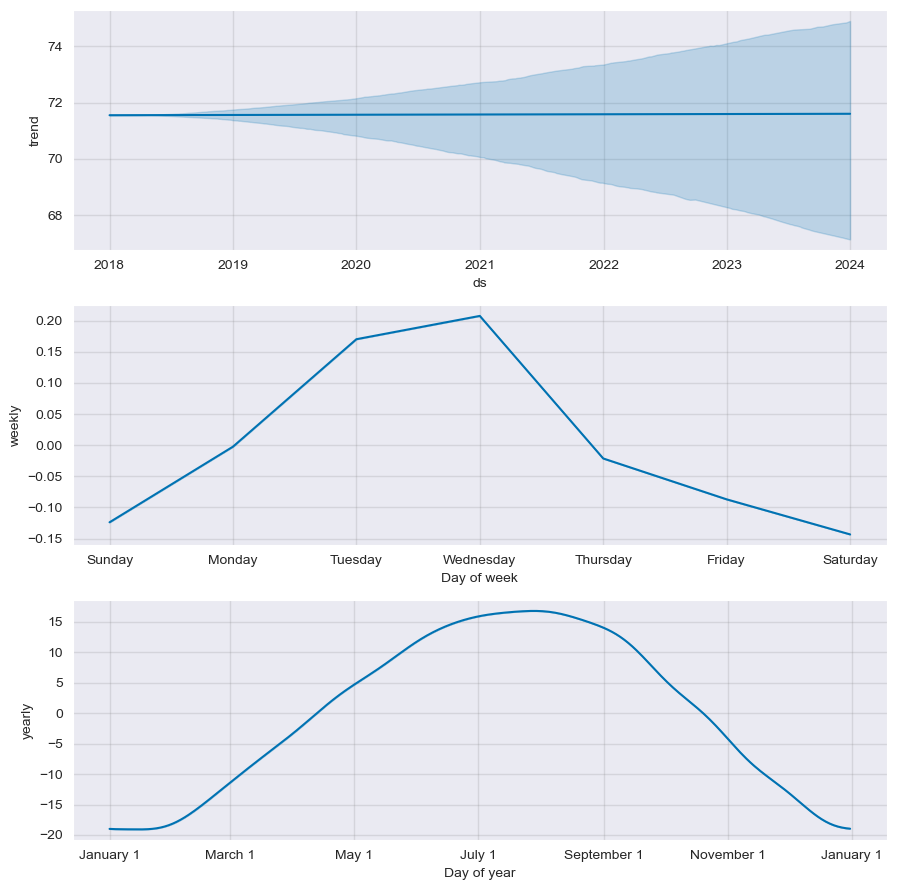

In [42]:
fig = model.plot_components(test_forecast)
plt.show()

Now plotting our forecast vs actuals to get an idea of model accuracy

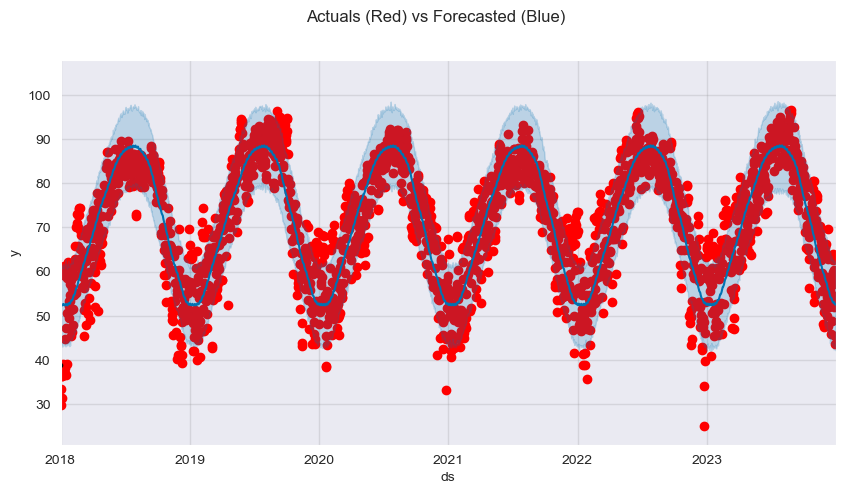

In [52]:



fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(test.index, test['temperature_2m'], color='r')
fig = model.plot(test_forecast, ax=ax)
ax.set_xbound(lower=pd.to_datetime('2018-01-01'), upper=pd.to_datetime('2023-12-31'))
#ax.set_ylim(0, 60000)
plot = plt.suptitle('Actuals (Red) vs Forecasted (Blue)')
plt.show()

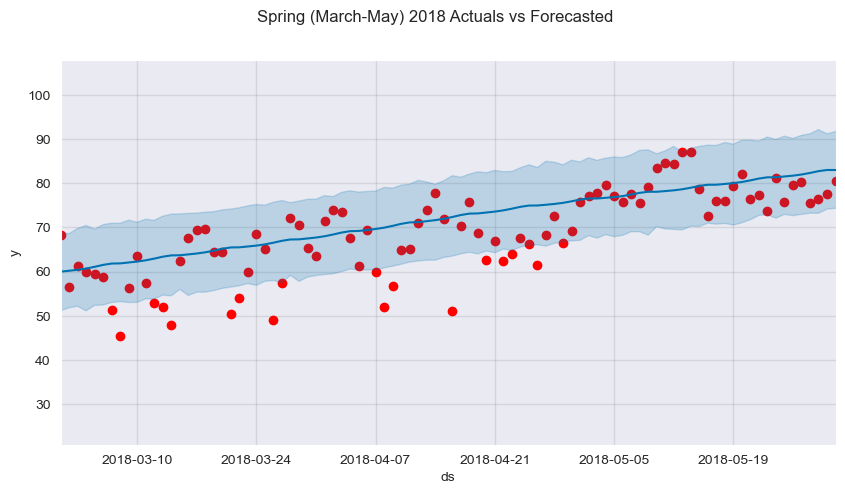

In [66]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(test.index, test['temperature_2m'], color='r')
fig = model.plot(test_forecast, ax=ax)
ax.set_xbound(lower=pd.to_datetime('2018-03-01'), upper=pd.to_datetime('2018-05-31'))
#ax.set_ylim(0, 60000)
plot = plt.suptitle('Spring (March-May) 2018 Actuals vs Forecasted')
plt.show()

Now i will be running a series of cross-validation tests to ensure the model is able to fit various parts of the data, and ensure a relatively constant mean error across all years

In [56]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon = '365 days')

  0%|          | 0/51 [00:00<?, ?it/s]

19:20:37 - cmdstanpy - INFO - Chain [1] start processing
19:20:37 - cmdstanpy - INFO - Chain [1] done processing
19:20:37 - cmdstanpy - INFO - Chain [1] start processing
19:20:37 - cmdstanpy - INFO - Chain [1] done processing
19:20:37 - cmdstanpy - INFO - Chain [1] start processing
19:20:37 - cmdstanpy - INFO - Chain [1] done processing
19:20:37 - cmdstanpy - INFO - Chain [1] start processing
19:20:37 - cmdstanpy - INFO - Chain [1] done processing
19:20:37 - cmdstanpy - INFO - Chain [1] start processing
19:20:37 - cmdstanpy - INFO - Chain [1] done processing
19:20:38 - cmdstanpy - INFO - Chain [1] start processing
19:20:38 - cmdstanpy - INFO - Chain [1] done processing
19:20:38 - cmdstanpy - INFO - Chain [1] start processing
19:20:38 - cmdstanpy - INFO - Chain [1] done processing
19:20:38 - cmdstanpy - INFO - Chain [1] start processing
19:20:38 - cmdstanpy - INFO - Chain [1] done processing
19:20:38 - cmdstanpy - INFO - Chain [1] start processing
19:20:38 - cmdstanpy - INFO - Chain [1]

In [57]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1992-05-12,73.576070,65.512643,81.589987,81.536003,1992-05-11
1,1992-05-13,73.487712,65.713625,81.239437,75.686005,1992-05-11
2,1992-05-14,73.166584,65.221482,81.352066,79.015999,1992-05-11
3,1992-05-15,73.455051,64.918355,81.244333,80.096001,1992-05-11
4,1992-05-16,74.602334,66.916951,82.569919,80.096001,1992-05-11


In [59]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,52.829991,7.268424,5.842812,0.090653,0.070426,0.088038,0.767624
1,38 days,53.357177,7.304600,5.877429,0.091264,0.071075,0.088594,0.766571
2,39 days,53.793983,7.334438,5.889283,0.091646,0.071261,0.088860,0.767119
3,40 days,54.165706,7.359735,5.903251,0.091878,0.071539,0.089054,0.765486
4,41 days,54.101488,7.355371,5.892341,0.091616,0.071261,0.088831,0.764706
...,...,...,...,...,...,...,...,...
324,361 days,60.387221,7.770922,6.179364,0.099129,0.070985,0.095345,0.727640
325,362 days,60.012945,7.746802,6.154769,0.098618,0.070039,0.094865,0.729504
326,363 days,60.242018,7.761573,6.175079,0.098799,0.070970,0.095107,0.726249
327,364 days,60.577705,7.783168,6.191925,0.099022,0.071036,0.095337,0.723857


The plot here is showing a constant mean error across various spans of time. I feel confident there are no suprises or random patterns being considered for the forecast. This is to be expected as temperature data is highly predictable at a high level. 

/Users/cstone/anaconda3/lib/python3.11/site-packages/prophet/plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/Users/cstone/anaconda3/lib/python3.11/site-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


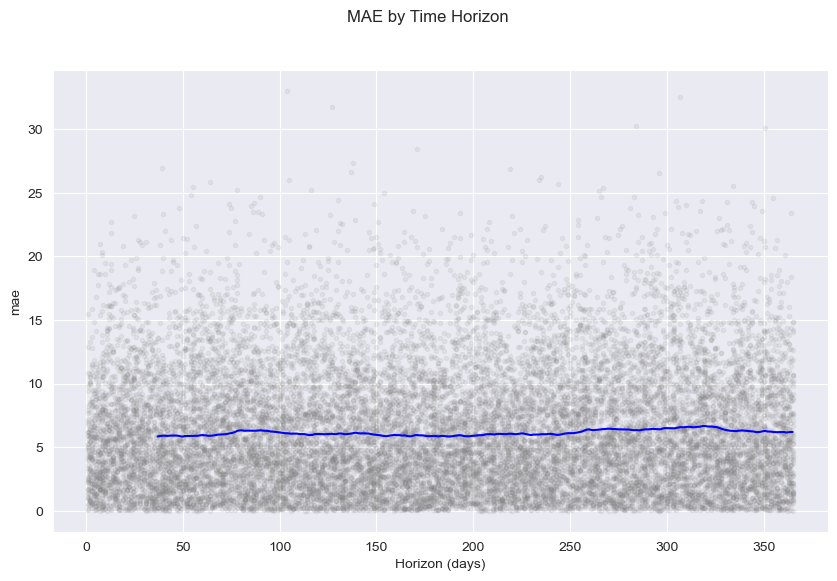

In [62]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mae')
plot = plt.suptitle('MAE by Time Horizon')
plt.show()

Now I'll be running a series of methods to actually project our forecast out into the future by one year. 

In [67]:
future_df = model.make_future_dataframe(periods=365, freq='d', include_history=False)
forecast = model.predict(future_df)

In [69]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
360,2018-12-27,71.560117,43.440911,61.453055,71.406277,71.723788,-18.789639,-18.789639,-18.789639,-0.021338,-0.021338,-0.021338,-18.768301,-18.768301,-18.768301,0.0,0.0,0.0,52.770478
361,2018-12-28,71.560140,43.977951,61.512872,71.405234,71.725008,-18.920565,-18.920565,-18.920565,-0.086984,-0.086984,-0.086984,-18.833582,-18.833582,-18.833582,0.0,0.0,0.0,52.639574
362,2018-12-29,71.560163,43.498940,61.637581,71.404517,71.726334,-19.031063,-19.031063,-19.031063,-0.143266,-0.143266,-0.143266,-18.887797,-18.887797,-18.887797,0.0,0.0,0.0,52.529099
363,2018-12-30,71.560186,43.992917,62.194334,71.403834,71.727659,-19.055890,-19.055890,-19.055890,-0.123848,-0.123848,-0.123848,-18.932042,-18.932042,-18.932042,0.0,0.0,0.0,52.504296
364,2018-12-31,71.560209,43.856731,61.864878,71.403154,71.728925,-18.969840,-18.969840,-18.969840,-0.002375,-0.002375,-0.002375,-18.967466,-18.967466,-18.967466,0.0,0.0,0.0,52.590368


In [77]:
full_data = df.reset_index() \
    .rename(columns={'index': 'ds','temperature_2m': 'y'}) 
full_data = full_data.rename(columns={'date':'ds'})
full_data['ds'] = pd.to_datetime(full_data['ds']).dt.tz_localize(None)

In [78]:
from prophet import Prophet
forecast_model = Prophet()
forecast_model.fit(full_data)

19:35:37 - cmdstanpy - INFO - Chain [1] start processing
19:35:38 - cmdstanpy - INFO - Chain [1] done processing


In [79]:
future_df = forecast_model.make_future_dataframe(periods=365, freq='d', include_history=False)
forecast = forecast_model.predict(future_df)

In [82]:
full_data_with_forecast = pd.concat([full_data, forecast], axis=0)

In [90]:
full_data_with_forecast.to_csv('weather_data.csv')


Plotting forecast out to one year, with a confidence interval

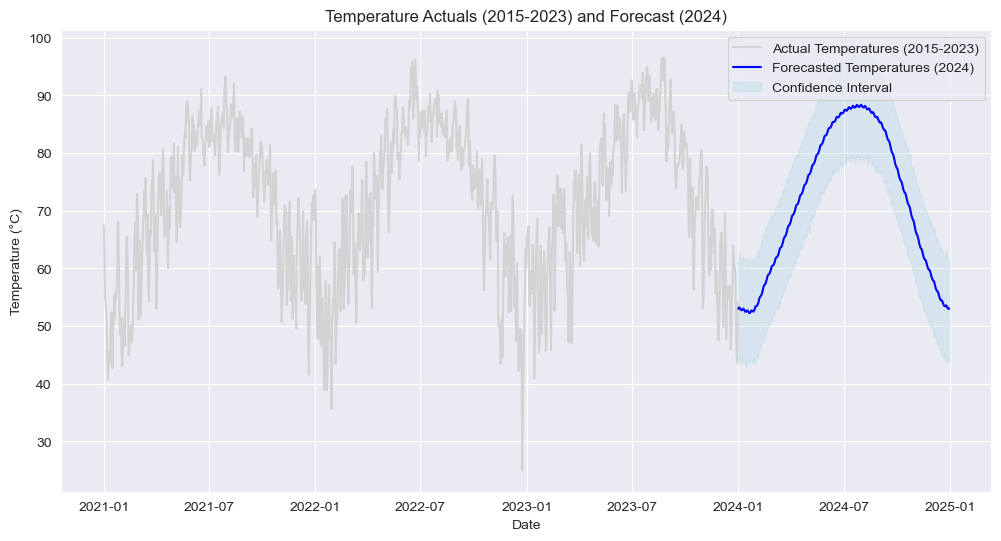

In [98]:
actuals = full_data_with_forecast[(full_data_with_forecast['ds'] >= '2021-01-01') & (full_data_with_forecast['ds'] < '2024-01-01')]
forecast = full_data_with_forecast[full_data_with_forecast['ds'] >= '2024-01-01']


plt.figure(figsize=(12, 6))


plt.plot(actuals['ds'], actuals['y'], label='Actual Temperatures (2015-2023)', color='lightgrey')


plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted Temperatures (2024)', color='blue')


plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], 
                 color='lightblue', alpha=0.3, label='Confidence Interval')

# Add labels, title, and legend
plt.title('Temperature Actuals (2015-2023) and Forecast (2024)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()